## Aircraft Detection - Deep Learning Project

In [1]:
import os
import json
import random
import pandas as pd
import skimage.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import BBOX


In [2]:
data_root = os.getcwd()
print(data_root)
#r"D:\RarePlanes\data"
train_imgs = os.path.join(data_root, r'C:\Users\artur\Documents\GitHub\aircraft-detection\data\train')
annot_dir = os.path.join(data_root, r'C:\Users\artur\Documents\GitHub\aircraft-detection\data\annot\rareplanes.json')
train_im_list = [z for z in os.listdir(train_imgs) if z.endswith('.png')]
f = open(annot_dir)
data = json.load(f)
print(len(train_im_list))
print(len(data['images']))
assert len(train_im_list) == len(data['images'])

def imgs_annot_aggregator(iter):
    print("Running imgs_annot_aggregator...")
    final = np.zeros((iter,4))
    bounding_boxes = []
    image_names = []
    instances_img = []
    amount_matches = []
    class_type = []
    for j in range(iter): 
        instances_img = []                        
        img = random.sample(train_im_list,1)
        image_names.append(img[0])
        for i in range(len(data['categories'])):
            if [data['categories'][i]['image_fname']] == img:
                instances_img.append(data['categories'][i]['id'])
        for l in range(len(instances_img)):
            for i in range(len(data['categories'])):
                if data['categories'][i]['id'] == instances_img[l]:
                    bounding_boxes.append(data['categories'][i]['bbox'])
                    class_type.append(data['categories'][i]['role'])
        amount_matches.append(len(instances_img))
    final = amount_matches, image_names, bounding_boxes, class_type
    return final, image_names

def bbox_points(data_annot):
    print("Running bbox_points...")
    name = []
    x_org = []
    y_org = []
    x_dist = []
    y_dist = []
    bbox = []
    class_type = []
    file_path = []
    itr = 0
    for i in range(len(data_annot[0])):
        for j in range(data_annot[0][i]):
            name.append(data_annot[1][i])
            class_type.append(data_annot[3][i])
            x_org.append(data_annot[2][j+itr][0])
            y_org.append(data_annot[2][j+itr][1])
            x_dist.append(data_annot[2][j+itr][2])
            y_dist.append(data_annot[2][j+itr][3])
            bbox.append([data_annot[2][j+itr][0],data_annot[2][j+itr][1],data_annot[2][j+itr][0]+data_annot[2][j+itr][2],data_annot[2][j+itr][1]+data_annot[2][j+itr][3]])
            file_path.append(os.path.join(train_imgs, data_annot[1][i]))
        itr = itr + data_annot[0][i]
    df = pd.DataFrame(
    {'name': name,
     'class': class_type,
     'x_org': x_org,
     'y_org': y_org,
     'x_dist': x_dist,
     'y_dist': y_dist,
     'bbox': bbox,
     'file_path': file_path
    })
    return df

final, img_name = imgs_annot_aggregator(1)
result = bbox_points(final)
result.head()

c:\Users\artur\Documents\GitHub\aircraft-detection\src
5815
5815
Running imgs_annot_aggregator...
Running bbox_points...


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,24_1040010011273000_tile_210.png,Small Civil Transport/Utility,50.413857,260.568523,35.860557,26.351208,"[50.41385724116117, 260.568523414433, 86.27441...",C:\Users\artur\Documents\GitHub\aircraft-detec...


## Testing random images

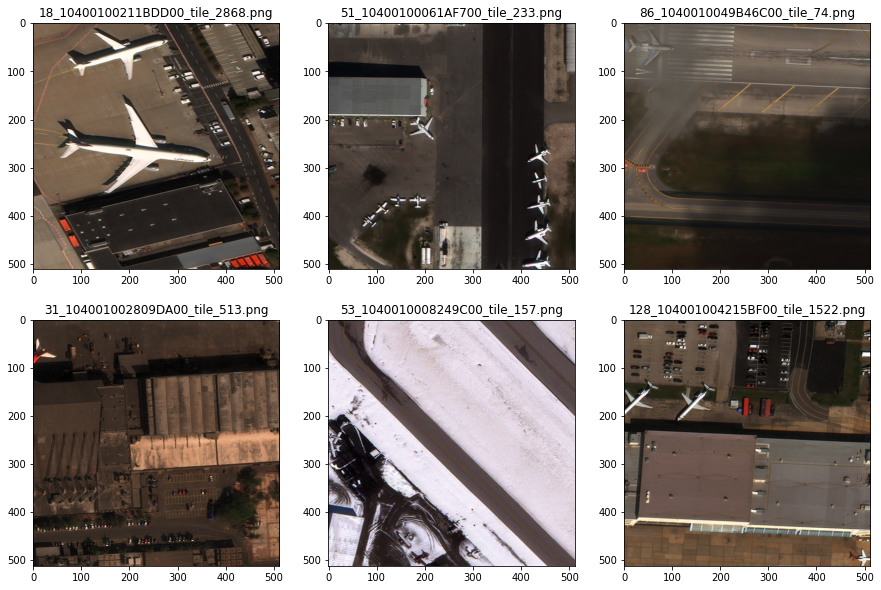

In [3]:
dir_tmp = train_imgs
rows, cols = 2, 3
figsize = 5
rand_selection = random.sample(train_im_list, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = os.path.join(train_imgs, rand_selection[i])
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

# Loading the entire Dataset

In [4]:
print(len(train_im_list))
amount_imgs = 100

final_data, img_name_data = imgs_annot_aggregator(amount_imgs)#len(train_im_list))
result_data = bbox_points(final_data)

print(np.shape(result_data))

result_data.head()

5815
Running imgs_annot_aggregator...
Running bbox_points...
(285, 8)


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,96_10400100096C2500_tile_1079.png,Small Civil Transport/Utility,22.238869,32.140503,43.539212,25.307167,"[22.23886902630329, 32.1405029296875, 65.77808...",C:\Users\artur\Documents\GitHub\aircraft-detec...
1,96_10400100096C2500_tile_1079.png,Small Civil Transport/Utility,196.667837,104.796563,54.696135,23.946567,"[196.66783671081066, 104.79656280204654, 251.3...",C:\Users\artur\Documents\GitHub\aircraft-detec...
2,96_10400100096C2500_tile_1079.png,Small Civil Transport/Utility,219.661983,74.999415,36.464090,25.171107,"[219.66198299080133, 74.99941465631127, 256.12...",C:\Users\artur\Documents\GitHub\aircraft-detec...
3,96_10400100096C2500_tile_1079.png,Small Civil Transport/Utility,462.257029,17.173899,40.545891,16.599325,"[462.25702929496765, 17.173898849636316, 502.8...",C:\Users\artur\Documents\GitHub\aircraft-detec...
4,96_10400100096C2500_tile_1079.png,Small Civil Transport/Utility,477.495753,34.317464,34.504247,20.953246,"[477.4957534894347, 34.3174635283649, 512.0000...",C:\Users\artur\Documents\GitHub\aircraft-detec...


In [5]:
class_dict = {'Small Civil Transport/Utility': 0, 
              'Medium Civil Transport/Utility': 1, 
              'Large Civil Transport/Utility': 2, 
              "Military Transport/Utility/AWAC": 3,
              "Military Fighter/Interceptor/Attack": 4,
              "Military Bomber": 5,
              "Military Trainer": 6
              }

result_data['class'] = result_data['class'].apply(lambda x: class_dict[x])

In [6]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros([rows,cols])
    bb = bb.astype(int)
    Y[bb[1]:(bb[1]+bb[3]),bb[0]:(bb[0]+bb[2])] = 1.
    return Y

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[2],x[3],x[4],x[5]])

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# Visualize Masks

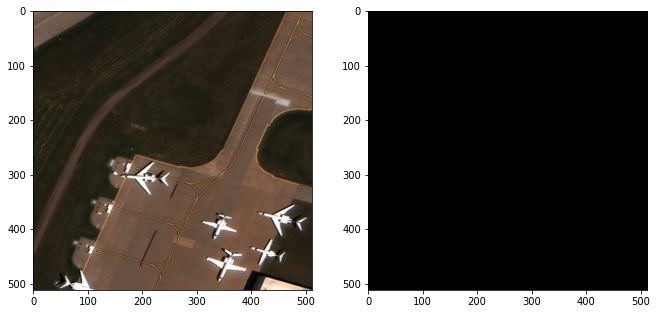

In [14]:
row = int(np.random.uniform(low=0, high=100, size=(1,)))

test_img = os.path.join(train_imgs, str(result_data['name'][row]))
rows_image = []

for i in range(49):
    if result_data['name'][i] == result_data['name'][row]:
        rows_image.append(i)

im = skimage.io.imread(test_img)
bb = []
final_y = np.zeros((512,512))

for i in range(len(rows_image)):
    bb.append(create_bb_array(result_data.values[rows_image[i]]))
    Y = create_mask(bb[i],im)
    final_y = np.where(final_y == 0, Y, final_y)

figsize = 11
f, axarr = plt.subplots(1,2,figsize=(figsize*1, figsize*2))
axarr[0].imshow(im)
axarr[1].imshow(final_y, cmap='gray')

# Data Augmentation

In [15]:
new_size = 128
ratio = int(512/new_size)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=1)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))


In [16]:
result_data.head()

,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,96_10400100096C2500_tile_1079.png,0,22.238869,32.140503,43.539212,25.307167,"[22.23886902630329, 32.1405029296875, 65.77808...",C:\Users\artur\Documents\GitHub\aircraft-detec...
1,96_10400100096C2500_tile_1079.png,0,196.667837,104.796563,54.696135,23.946567,"[196.66783671081066, 104.79656280204654, 251.3...",C:\Users\artur\Documents\GitHub\aircraft-detec...
2,96_10400100096C2500_tile_1079.png,0,219.661983,74.999415,36.464090,25.171107,"[219.66198299080133, 74.99941465631127, 256.12...",C:\Users\artur\Documents\GitHub\aircraft-detec...
3,96_10400100096C2500_tile_1079.png,0,462.257029,17.173899,40.545891,16.599325,"[462.25702929496765, 17.173898849636316, 502.8...",C:\Users\artur\Documents\GitHub\aircraft-detec...
4,96_10400100096C2500_tile_1079.png,0,477.495753,34.317464,34.504247,20.953246,"[477.4957534894347, 34.3174635283649, 512.0000...",C:\Users\artur\Documents\GitHub\aircraft-detec...


C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_902.png


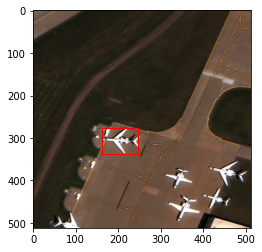

In [18]:
pic = 50 #int(np.random.uniform(low=0.0, high=100, size=None))

print(result_data['file_path'][pic])

im = cv2.imread(str(result_data['file_path'][pic]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, result_data['bbox'][pic])

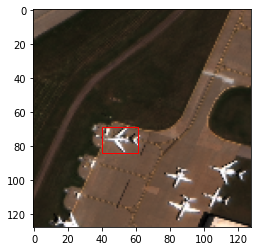

In [19]:
im, bb = BBOX.transformsXY(str(result_data['file_path'][pic]), np.array(result_data['bbox'][pic],dtype=np.int32),new_size,ratio)
show_corner_bb(im, bb)

# Training


In [20]:
result_data = result_data.reset_index()

In [21]:
X = result_data[['file_path','bbox']]
Y = result_data['class']

X.head()

,file_path,bbox
0,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[22.23886902630329, 32.1405029296875, 65.77808..."
1,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[196.66783671081066, 104.79656280204654, 251.3..."
2,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[219.66198299080133, 74.99941465631127, 256.12..."
3,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[462.25702929496765, 17.173898849636316, 502.8..."
4,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[477.4957534894347, 34.3174635283649, 512.0000..."


In [22]:
Y.head() 

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

In [23]:
data_frame_int = pd.DataFrame()
from BBOX import *

for i in range(len(result_data['file_path'])):
    print(result_data['file_path'][i])
    im, bb = transformsXY(str(result_data['file_path'][i]), np.array(result_data['bbox'][i]),new_size,ratio)
    data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)


C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\96_10400100096C2500_tile_1079.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\96_10400100096C2500_tile_1079.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\96_10400100096C2500_tile_1079.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\96_10400100096C2500_tile_1079.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\96_10400100096C2500_tile_1079.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\113_10400100460EF400_tile_82.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\113_10400100460EF400_tile_82.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png


C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png


C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\trai

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_10400100202A2200_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_10400100202A2200_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\10_1040010039679A00_tile_40.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\10_1040010039679A00_tile_40.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\10_1040010039679A00_tile_40.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_440.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_10400100360CD600_tile_886.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_10400100360CD600_tile_886.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_523.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_10400100061AF700_tile_461.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\100_1040010046CD1500_tile_235.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\100_1040010046CD1500_tile_235.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\100_1040010046CD1500_tile_235.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\100_1040010046CD1500_tile_235.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_902.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_902.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_902.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_902.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_902.png
C:\Users\artur\Documents\GitHub\aircraft-detec

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\86_1040010043890900_tile_111.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_10400100211BDD00_tile_3596.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_10400100061AF700_tile_446.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_10400100061AF700_tile_446.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_10400100211BDD00_tile_4372.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_91.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\8_104001001051CB00_tile_70.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\8_104001001051CB00_tile_70.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\8_104001001051CB00_tile_70.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_10400100460EF400_tile_226.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\123_10400100458F0500_tile_109.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\130_104001002E47CD00_tile_663.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\118_1040010023C25400_tile_292.png
C:\Users\artur\Documents\GitHub\aircraft

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\118_104001000A341F00_tile_654.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\118_104001000A341F00_tile_654.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_10400100061AF700_tile_678.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_10400100061AF700_tile_678.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\114_1040010049AD0900_tile_275.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\114_1040010049AD0900_tile_275.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\114_1040010049AD0900_tile_275.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\114_1040010049AD0900_tile_275.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\111_1040010042793C00_tile_341.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\111_1040010042793C00_tile_341.png
C:\Users\artur\Documents\GitHub\aircraft-d

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010041460F00_tile_19.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010041460F00_tile_19.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010041460F00_tile_19.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\59_104001001DC7F200_tile_524.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\19_10400100036EE200_tile_75.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\19_10400100036EE200_tile_75.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\130_104001002E47CD00_tile_903.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_1040050010DC4900_tile_3729.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\100_1040010029990A00_tile_418.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\100_1040010029990A00_tile_418.png
C:\Users\artur\Documents\GitHub\aircraft-detection\

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_1040010042D13B00_tile_446.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_1040010024086400_tile_628.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\106_1040010044D30600_tile_56.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_687.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_588.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_588.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\9_10400100310B0100_tile_148.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_10400100101BE000_tile_758.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_10400100101BE000_tile_758.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_10400100101BE000_tile_758.png
C:\Users\artur\Documents\GitHub\aircraft-detection\dat

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\97_104001003D4C1D00_tile_247.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\97_104001003D4C1D00_tile_247.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\97_104001003D4C1D00_tile_247.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\97_104001003D4C1D00_tile_247.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\97_104001003D4C1D00_tile_247.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_10400100290F5300_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_10400100290F5300_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_10400100290F5300_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_10400100290F5300_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_10400100290F5300_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\50_10400100350A5200_tile_105.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_1040010024086400_tile_635.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\99_104001001A4EEC00_tile_71.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\23_104001001E51BE00_tile_1134.png
C:\Users\artur\Documents\GitHub\aircraft-detection

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\39_104001001D4E6100_tile_544.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\23_104001001E51BE00_tile_2287.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_1040050010DC4900_tile_3269.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_1040050010DC4900_tile_3269.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_63.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_63.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_63.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_63.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_63.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\66_1040010037570000_tile_63.png
C:\Users\artur\Documents\GitHub\aircraft-detection\da

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\31_104001002809DA00_tile_444.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\98_104001000BA69D00_tile_117.png
C:\Users\artur\Documents\GitHub\aircraft-detection

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\91_1040010039040600_tile_42.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\91_1040010039040600_tile_42.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_10400100202B8A00_tile_66.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_10400100202B8A00_tile_66.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_10400100211BDD00_tile_4215.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_10400100211BDD00_tile_4215.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\59_104001001DC7F200_tile_474.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\59_104001001DC7F200_tile_474.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\59_104001001DC7F200_tile_474.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\130_104001000F25CE00_tile_663.png
C:\Users\artur\Documents\GitHub\aircraft-detection\da

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\47_104001001D2C7A00_tile_152.png
C:\Users\artur\Documents\GitHub\aircraft-detection

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_188.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_1040010019345B00_tile_785.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\4_1040010019345B00_tile_785.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_1040010042D13B00_tile_655.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_1040010042D13B00_tile_655.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_1040010049B46C00_tile_253.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_1040010049B46C00_tile_253.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_1040010049B46C00_tile_253.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\84_1040010049B46C00_tile_253.png
C:\Users\artur\Documents\GitHub\aircraft-detection\d

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_10400100211BDD00_tile_3281.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\23_104001002E8B7900_tile_2091.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_104001001CAC2B00_tile_168.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\56_104001000F345100_tile_153.png
C:\Users\artur\Documents\GitHub\aircraft-detecti

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_10400100202B8A00_tile_72.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_10400100202B8A00_tile_72.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_588.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_588.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\60_1040010046430200_tile_200.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\60_1040010046430200_tile_200.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_104001000953A900_tile_110.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_104001000953A900_tile_110.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_104001000953A900_tile_110.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\3_104001000953A900_tile_110.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\tr

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\106_1040010043890900_tile_72.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\18_10400100211BDD00_tile_4319.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_422.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_422.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_422.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\54_104001003D4C9C00_tile_422.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\88_1040010040D29200_tile_435.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\20_1040010038CAE700_tile_161.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\107_1040010043B54900_tile_211.png
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\107_1040010043B54900_tile_211.png
C:\Users\artur\Documents\GitHub\aircraft-detect

C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\2807240051.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame_int = data_frame_int.append({'file_path': result_data['file_path'][i], 'bbox': bb}, ignore_index=True)
C:\Users\artur\AppData\Local\Temp\ipykernel_13060\28

In [19]:
data_frame_int.head()

,file_path,bbox
0,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[82.0, 92.0, 97.0, 101.0]"
1,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[99.0, 97.0, 119.0, 108.0]"
2,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[7.0, 8.0, 15.0, 13.0]"
3,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[54.0, 101.0, 84.0, 128.0]"
4,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[119.0, 124.0, 128.0, 128.0]"


# Pre Processing

#### Test image (reduced)

In [24]:
import warnings
import BBOX
warnings.simplefilter(action='ignore', category=FutureWarning)

def image_merger(result_data):
    final_data_frame = pd.DataFrame()
    print("Original length of result_data: ", len(result_data['file_path']))
    imgs_used = []

    for i in range(len(result_data['file_path'])):
        checker = True
        img_path_test = result_data['file_path'][i]

        for x in range(len(imgs_used)):
            if imgs_used[x] == img_path_test:
                checker = False
        
        if checker == True:
            imgs_used.append(img_path_test)
            indx_number = []

            for j in range(len(result_data['file_path'])):
                if img_path_test == result_data['file_path'][j]:
                    indx_number.append(j)

            final_bbxs = []
            for h in range(len(indx_number)):
                bbox = result_data['bbox'][indx_number[h]]
                final_bbxs.append(BBOX.BBOX(bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1]))
            
            final_data_frame = final_data_frame.append({'path': img_path_test, 'final_bbx': final_bbxs}, ignore_index=True)

    return final_data_frame

df_final = image_merger(data_frame_int)
df_final.head()


print(df_final['final_bbx'][0])
print(df_final['path'][1])

Original length of result_data:  285
[<BBOX.BBOX object at 0x0000022ABF3A3340>, <BBOX.BBOX object at 0x0000022ABF3A3280>, <BBOX.BBOX object at 0x0000022ABF3A3220>, <BBOX.BBOX object at 0x0000022ABF3A31C0>, <BBOX.BBOX object at 0x0000022ABF3A3160>]
C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\113_10400100460EF400_tile_82.png


### Function that generates bbox's based on a center point

(128, 128, 3)
Width:  128
Heigth:  128
7500
Width:  128
Heigth:  128


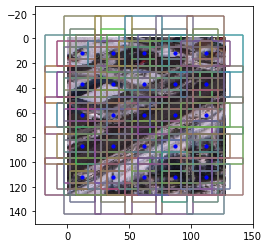

In [183]:
img_test_path_curr = df_final['path'][0]

import importlib
importlib.reload(BBOX)

im, bb = transformsXY(str(result_data['file_path'][i]), np.array(result_data['bbox'][i]),new_size,ratio)

print(im.shape)
s = 5
bboxs = BBOX.generate(s, 130//4, 10, im.shape)
print(len(bboxs))
BBOX.display(bboxs, img_test_path_curr, s, new_size, ratio)

### IoU - Interception over Union

In [26]:
def iou(boxA, boxB):
    xA = max(boxA.arr[0], boxB.arr[0])
    yA = max(boxA.arr[1], boxB.arr[1])
    xB = min(boxA.arr[2], boxB.arr[2])
    yB = min(boxA.arr[3], boxB.arr[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA.arr[2] - boxA.arr[0] + 1) * (boxA.arr[3] - boxA.arr[1] + 1)
    boxBArea = (boxB.arr[2] - boxB.arr[0] + 1) * (boxB.arr[3] - boxB.arr[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

rec1 = BBOX.BBOX(120,120,60,60)
rec2 = BBOX.BBOX(120,120,60,60)

result_iou = iou(rec1,rec2) 
print(result_iou)

1.0


In [27]:
def app_flat(my_array):
    out = np.zeros_like(my_array)
    idx  = my_array.argmax()
    out.flat[idx] = 1
    return out

In [28]:
import BBOX

def get_vectors_mask_wise(df_final):
    for_real_tho = pd.DataFrame()

    for l in range(len(df_final['path'])):
        img_test_path_curr = df_final['path'][l]
        masks = df_final['final_bbx'][l]
        vector_f = np.zeros([np.shape(bboxs)[0],])

        for i in range(len(masks)):
            temp_vector = []
            for j in range(len(bboxs)):
                value = iou(masks[i],bboxs[j])
                temp_vector.append(value)
            temp_vector = np.array(temp_vector)
            return_temp_vector = app_flat(temp_vector) 
            vector_f = vector_f + return_temp_vector
        for_real_tho = for_real_tho.append({'path': img_test_path_curr, 'vector': vector_f}, ignore_index=True)

    return for_real_tho

for_real_tho = get_vectors_mask_wise(df_final)


In [29]:
for_real_tho.head()

,path,vector
0,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,C:\Users\artur\Documents\GitHub\aircraft-detec...,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
print(sum(for_real_tho['vector'][0]), for_real_tho['path'][0])
print(sum(for_real_tho['vector'][1]), for_real_tho['path'][1])
print(sum(for_real_tho['vector'][2]), for_real_tho['path'][2])
print(sum(for_real_tho['vector'][3]), for_real_tho['path'][3])
print(sum(for_real_tho['vector'][4]), for_real_tho['path'][4])

5.0 C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\96_10400100096C2500_tile_1079.png
2.0 C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\113_10400100460EF400_tile_82.png
26.0 C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\72_1040010042C71600_tile_38.png
2.0 C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\45_10400100202A2200_tile_152.png
3.0 C:\Users\artur\Documents\GitHub\aircraft-detection\data\train\10_1040010039679A00_tile_40.png


# Training

In [42]:
for_real_tho = for_real_tho.reset_index()

In [43]:
X = for_real_tho['path']
Y = for_real_tho['vector']

X.head()

0    C:\Users\artur\Documents\GitHub\aircraft-detec...
1    C:\Users\artur\Documents\GitHub\aircraft-detec...
2    C:\Users\artur\Documents\GitHub\aircraft-detec...
3    C:\Users\artur\Documents\GitHub\aircraft-detec...
4    C:\Users\artur\Documents\GitHub\aircraft-detec...
Name: path, dtype: object

In [44]:
Y.head()

0    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
4    [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
Name: vector, dtype: object

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train)

49    C:\Users\artur\Documents\GitHub\aircraft-detec...
70    C:\Users\artur\Documents\GitHub\aircraft-detec...
68    C:\Users\artur\Documents\GitHub\aircraft-detec...
15    C:\Users\artur\Documents\GitHub\aircraft-detec...
39    C:\Users\artur\Documents\GitHub\aircraft-detec...
                            ...                        
60    C:\Users\artur\Documents\GitHub\aircraft-detec...
71    C:\Users\artur\Documents\GitHub\aircraft-detec...
14    C:\Users\artur\Documents\GitHub\aircraft-detec...
92    C:\Users\artur\Documents\GitHub\aircraft-detec...
51    C:\Users\artur\Documents\GitHub\aircraft-detec...
Name: path, Length: 79, dtype: object


In [46]:
class AircraftDataset(Dataset):
    def __init__(self, paths, y, transforms=False):
        self.paths = paths.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y = self.y[idx]   
        return path, y

In [51]:
train_ds = AircraftDataset(X_train,y_train, transforms=True)
valid_ds = AircraftDataset(X_val,y_val)

('C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\107_1040010043B54900_tile_211.png', array([0., 0., 0., ..., 0., 0., 0.]))


In [53]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

In [54]:
print("Training data")
print("Number of points:", len(train_ds))
x, y = next(iter(train_dl))
print("Batch dimension (B x C x H x W):", x)

print("\nTest data")
print("Number of points:", len(valid_ds))
x, y = next(iter(valid_dl))
print("Batch dimension (B x C x H x W):", x)

Training data
Number of points: 79
Batch dimension (B x C x H x W): ('C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\18_10400100211BDD00_tile_4372.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\59_104001001DC7F200_tile_524.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\107_1040010043B54900_tile_222.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\130_104001000F25CE00_tile_663.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\54_10400100061AF700_tile_446.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\45_10400100202A2200_tile_152.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\54_1040010042D13B00_tile_655.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\47_104001001D2C7A00_tile_152.png', 'C:\\Users\\artur\\Documents\\GitHub\\aircraft-detection\\data\\train\\50_104001

In [136]:
from torch.nn.modules.pooling import MaxPool1d
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d

class AircraftModel(nn.Module):
    def __init__(self):
        super(AircraftModel, self).__init__()
        self.conv = nn.Sequential(
            Conv2d(3,192,kernel_size=7,stride=2),
            nn.LeakyReLU(0.1),
            MaxPool2d(2,2),
            Conv2d(192,256,3,1),
            nn.LeakyReLU(0.1),
            MaxPool2d(2,2),
            Conv2d(256,128,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(128,256,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(256,256,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(256,512,1,1),
            nn.LeakyReLU(0.1),
            MaxPool2d(2,2),
            Conv2d(512,256,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(256,512,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(512,256,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(256,512,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(512,256,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(256,512,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(512,256,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(256,512,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(512,1024,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(1024,512,1,1),
            nn.LeakyReLU(0.1),
            # MaxPool2d(2,2),
            Conv2d(512,1024,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(1024,512,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(512,1024,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(1024,512,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(512,1024,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(1024,1024,1,2),
            nn.LeakyReLU(0.1),
            Conv2d(1024,1024,1,1),
            nn.LeakyReLU(0.1),
            Conv2d(1024,1024,1,1),
            nn.LeakyReLU(0.1),
            nn.Flatten(start_dim=1)
        )

        self.connected = nn.Sequential(
            nn.Linear(128*128,out_features=1024, bias=False),
            nn.ReLU(), 
            nn.LazyLinear(out_features=len(bboxs), bias=False)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.connected(x)
        return x

model = AircraftModel()
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

AircraftModel(
  (conv): Sequential(
    (0): Conv2d(3, 192, kernel_size=(7, 7), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.1)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (16): LeakyReLU(negative_slope=0.1)
    (1

c:\Users\artur\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [182]:
lr = 0.002

loss_fn = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr)  

print(loss_fn)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)


In [138]:
# Test the forward pass with dummy data
batchsize = 4
out = model(torch.randn(batchsize,3, 128, 128, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")

Output shape: torch.Size([4, 7500])
Output logits:
[[-0.00044805 -0.00524541 -0.00368745 ... -0.00494159 -0.00018575
   0.0040521 ]
 [-0.00044805 -0.00524541 -0.00368745 ... -0.00494159 -0.00018575
   0.0040521 ]
 [-0.00044805 -0.00524541 -0.00368745 ... -0.00494159 -0.00018575
   0.0040521 ]
 [-0.00044805 -0.00524541 -0.00368745 ... -0.00494159 -0.00018575
   0.0040521 ]]


In [139]:
from sklearn import metrics

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

In [184]:
from torchvision import transforms
import time
import csv
import importlib
importlib.reload(BBOX)

convert_tensor = transforms.ToTensor()
num_epochs = 1
validation_every_steps = 1

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
    



start_time = str(time.time()) 

titles = ['learning rate', 'epochs', 'train_images','val_images', 's', 'loss_fn', 'optimizer']
hyper = [lr, num_epochs,len(train_ds),len(valid_ds),s,loss_fn,optimizer]

with open(f'hyper_{start_time}.csv', 'a', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow(titles)
            wr.writerow(hyper)


for epoch in range(num_epochs):
    print("Epoch number: ", epoch)

    train_accuracies_batches = []
    
    for inputs, targets in train_dl:
        new_inputs = []

        for i in range(len(inputs)):
            im = BBOX.transformsXY_im(inputs[i],new_size)
            tensor = convert_tensor(im)
            new_inputs.append(tensor)
            
        new_inputs = torch.stack(tuple(new_inputs),0)
        new_inputs, targets = new_inputs.to(device), targets.to(device) 

        # Forward pass, compute gradients, perform one training step.
        optimizer.zero_grad()
        output = model(new_inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        # we use output & target

        subtra = torch.subtract(output,targets)
        squared = torch.square(subtra)
        acc = torch.sum(squared)/len(bboxs)

        train_accuracies_batches.append(acc.detach().numpy())
        
        with open(f'logs_train_{start_time}.csv', 'a', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow([int(acc)])

        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in valid_dl:
                    new_inputs = []

                    for i in range(len(inputs)):
                        im = BBOX.transformsXY_im(inputs[i],new_size)
                        tensor = convert_tensor(im)
                        new_inputs.append(tensor)
                        
                    new_inputs = torch.stack(tuple(new_inputs),0)
                    new_inputs, targets = new_inputs.to(device), targets.to(device) 

                    output = model(new_inputs)
                    loss = loss_fn(output, targets)

                    subtra = torch.subtract(output,targets)
                    squared = torch.square(subtra)
                    acc = torch.sum(squared)/len(bboxs)
                    valid_accuracies_batches.append(acc.detach().numpy()*len(inputs))

                    
                    with open(f'logs_val_{start_time}.csv', 'a', newline='') as myfile:
                        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                        wr.writerow([int(acc)])
                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(X_train))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")


torch.save(model.state_dict(), PATH)

Epoch number:  0
Step 1       training accuracy: 610.6599894002298
             test accuracy: 2464814425.4953465
Step 2       training accuracy: 7545809023.764241
             test accuracy: 708956.0061340971
Finished training.


NameError: name 'PATH' is not defined